In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection

# Data loading

In [2]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [3]:
dataset0 = sklearn.datasets.load_files('data/CroppedYale', shuffle=True)

data/CroppedYale/yaleB36/yaleB36_P00A+070E-35.pgm
34
yaleB36
2432


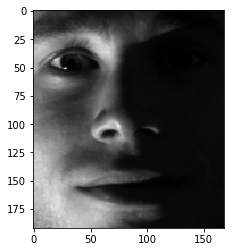

In [4]:
# Here is some sanity checks of the parsed dataset
idx0 = 10 #len(dataset0.filenames)-1
print(dataset0.filenames[idx0])
print(dataset0.target[idx0])
print(dataset0.target_names[dataset0.target[idx0]])
print(len(dataset0.filenames))
image0 = read_pgm2(dataset0.data[idx0])
plt.imshow(image0, plt.cm.gray)

In [5]:
# This cell includes the splittign of training and test set.
X = np.stack(map(read_pgm2, dataset0.data))
# X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = preprocessing.scale(X.astype(float),axis=1) # Mean removal and variance scaling

y_raw = dataset0.target
# idxs = [(y_raw == 0) | (y_raw == 1)|(y_raw == 2)|(y_raw == 3)|(y_raw == 4)|(y_raw == 5)]

# y_raw = y_raw[idxs]
# X = X[idxs]

enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y_raw.reshape(-1, 1)).toarray()
# y = y.reshape(-1)
# y = y[:size0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

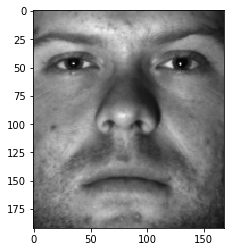

In [6]:
plt.imshow(X[y_raw==0][0].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

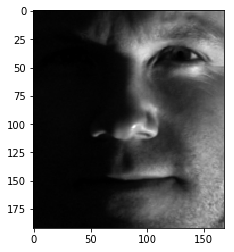

In [7]:
plt.imshow(X[y_raw==2][1].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

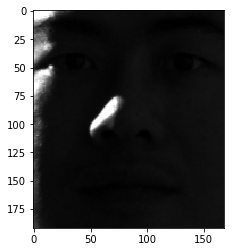

In [8]:
plt.imshow(X[y_raw==1][2].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

In [9]:
_, train_counts = np.unique(np.argmax(y_train,1), return_counts=True)
train_max = np.argmax(train_counts)
print(train_counts)
print(train_max)

[14 13 20 17 17 10 11  5 12 17 17 16 12  9 10 10 11 12  3 10 10 13 15 16  8
 12 19 15 17 18 10 16 11  8 15 18  9 10]
2


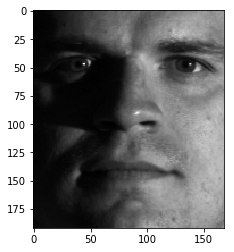

In [10]:
plt.imshow(X[y_raw==3][18].reshape(shapeX[1], shapeX[2]), plt.cm.gray)

In [11]:
baseline_acc = np.mean(np.argmax(y_test,1) == train_max)
baseline_acc

0.026721479958890029

# Optimal Encoding

In [12]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding

In [13]:
n_in = X.shape[-1]
k = 100
n_out = y.shape[-1]

sigma=5

widths = [300, 300]

In [14]:
encoder = MLP(n_in, k, widths)
decoder = MLP(k, n_out, widths)

In [15]:
oe = OptimalEncoding(encoder, decoder, k)

100%|██████████| 500/500 [00:32<00:00, 15.54it/s]


Sigma: 5.000000
Final task loss: -0.763474


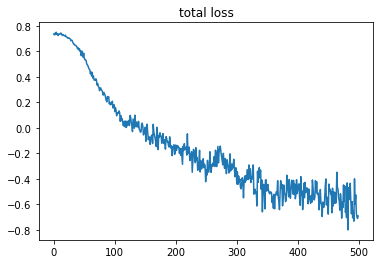

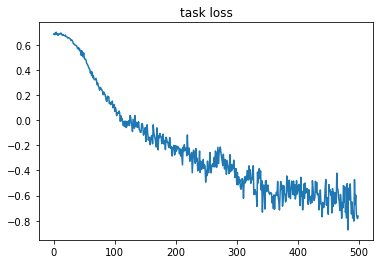

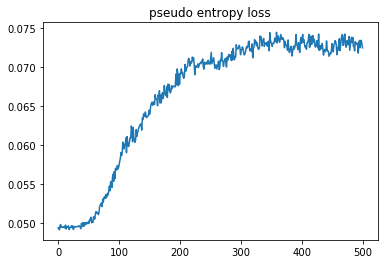

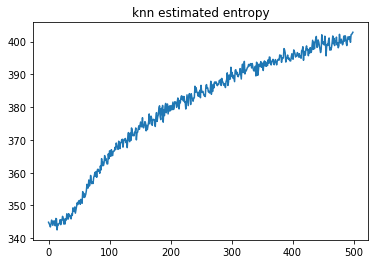

In [16]:
oe.train(X_train, y=y_train, 
         min_entropy=True, sigma = sigma, task = 'classification', 
         heteroskedastic = False, n_samples = 1,
         epochs=500, batch_size=100, lr=1e-3)

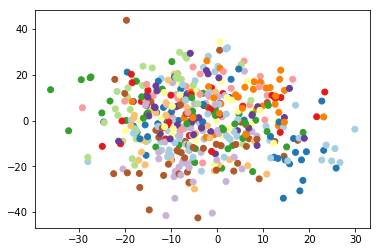

In [17]:
zhat_train = oe.encode(X_train, sigma=sigma)
plt.scatter(zhat_train[:,0], zhat_train[:,1], c = np.argmax(y_train,1), cmap=plt.get_cmap('Paired'))

In [18]:
pred_train = oe.decode(zhat_train)
pred_train = np.argmax(pred_train,1)

true_train = np.argmax(y_train,1)

acc_train = np.mean(pred_train == true_train)
print('train acc = %.3f' %acc_train)

train acc = 0.934


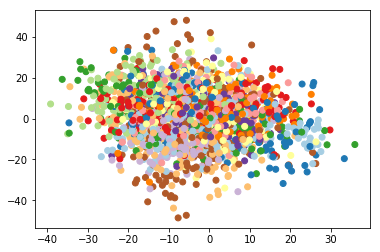

In [19]:
zhat_test = oe.encode(X_test, sigma=sigma)
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = np.argmax(y_test,1), cmap=plt.get_cmap('Paired'))

In [20]:
pred_test = oe.decode(zhat_test)
pred_test = np.argmax(pred_test,1)

true_test = np.argmax(y_test,1)

acc_test = np.mean(pred_test == true_test)
print('test acc = %.3f' %acc_test)

test acc = 0.582


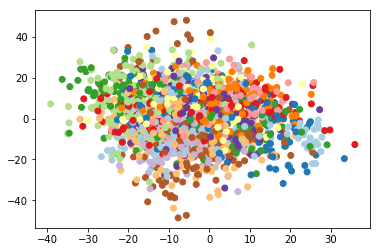

In [21]:
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = pred_test, cmap=plt.get_cmap('Paired'))

In [22]:
1/float(y.shape[-1])

0.02631578947368421

# SubOptimal Encoding

In [23]:
n_in = X.shape[-1]
k = 100
n_out = y.shape[-1]

sigma = 1

widths = [300, 300]

In [24]:
encoder = MLP(n_in, k, widths)
decoder = MLP(k, n_out, widths)

In [25]:
oe = OptimalEncoding(encoder, decoder, k)

100%|██████████| 500/500 [00:31<00:00, 15.86it/s]


Sigma: 1.000000
Final task loss: -1.052577


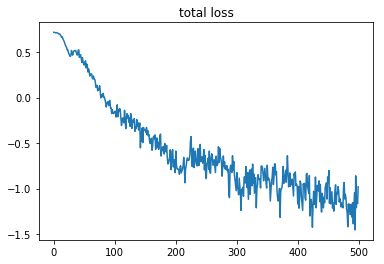

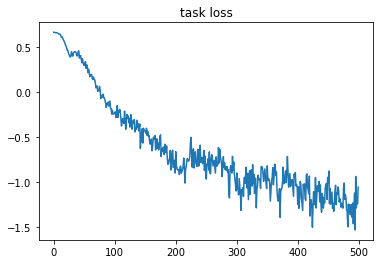

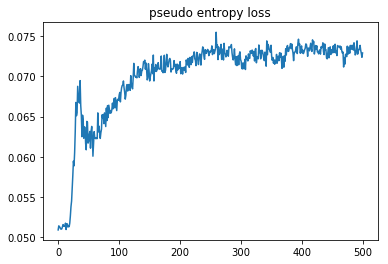

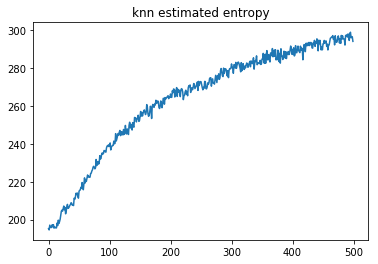

In [26]:
oe.train(X_train, y=y_train, 
         min_entropy=False, sigma = sigma, task = 'classification', 
         heteroskedastic = False, n_samples = 1,
         epochs=500, batch_size=100, lr=1e-3)

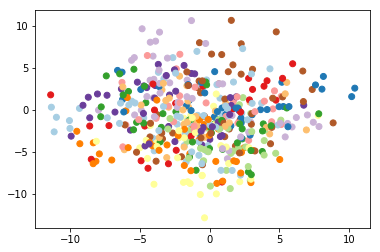

In [27]:
zhat_train = oe.encode(X_train, sigma=sigma)
plt.scatter(zhat_train[:,0], zhat_train[:,1], c = np.argmax(y_train,1), cmap=plt.get_cmap('Paired'))

In [28]:
pred_train = oe.decode(zhat_train)
pred_train = np.argmax(pred_train,1)

true_train = np.argmax(y_train,1)

acc_train = np.mean(pred_train == true_train)
print('train acc = %.3f' %acc_train)

train acc = 0.979


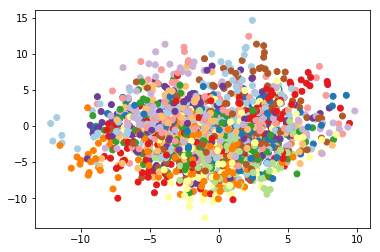

In [29]:
zhat_test = oe.encode(X_test, sigma=sigma)
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = np.argmax(y_test,1), cmap=plt.get_cmap('Paired'))

In [30]:
pred_test = oe.decode(zhat_test)
pred_test = np.argmax(pred_test,1)

true_test = np.argmax(y_test,1)

acc_test = np.mean(pred_test == true_test)
print('test acc = %.3f' %acc_test)

test acc = 0.660


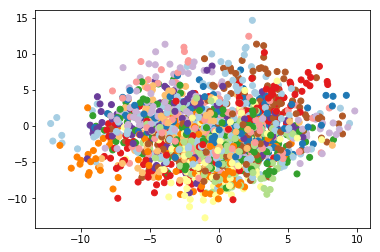

In [31]:
plt.scatter(zhat_test[:,0], zhat_test[:,1], c = pred_test, cmap=plt.get_cmap('Paired'))

In [32]:
1/float(y.shape[-1])

0.02631578947368421